<a href="https://colab.research.google.com/github/ykitaguchi77/Strabismus_AI_project/blob/main/Strabismus_3classes_RepVGG_Gradcam_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Strabismus: RepVGG_adabound**

In [ ]:
'''
データの構造
--------train------grav
    |          |---cont
    |
    |---val--------grav
    |          |---cont
    |
    |---test-------grav
               |---cont
'''

In [28]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import cv2

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True

"""                                
#サポートパッチのインポート
from google.colab.patches import cv2_imshow

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')
"""

"                                \n#サポートパッチのインポート\nfrom google.colab.patches import cv2_imshow\n\n#google driveをcolabolatoryにマウント\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

#**モジュール群**

full: 1284 -> train: 898, val: 256,test: 130
class_names -> ['cont', 'eso', 'exo']


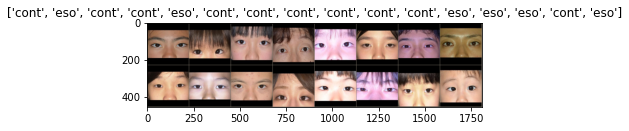

In [79]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])




#データセットをシャッフルして分割
#https://pystyle.info/pytorch-split-dataset/

class MySubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.indices)



data_dir = r"F:\Strabismus\Dataset_250px_20211116"
dataset = datasets.ImageFolder(data_dir)

# Train:val:testに 7:2:1 の割合で分割する。
train_rate =0.7
val_rate = 0.2

train_size = int(train_rate * len(dataset))
val_size = int(val_rate * len(dataset))
indices = np.arange(len(dataset))

train_dataset = MySubset(dataset, indices[:train_size], train_transform)
val_dataset = MySubset(dataset, indices[train_size:train_size+val_size], val_transform)
test_dataset = MySubset(dataset, indices[train_size+val_size:], test_transform)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)

class_names = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

print(f"full: {len(dataset)} -> train: {len(train_dataset)}, val: {len(val_dataset)},test: {len(test_dataset)}")
print("class_names -> "+str(class_names))



#少数の画像を可視化
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


#Defining early stopping class

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss







#Train models
def train_model(model, criterion, optimizer, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        ###################
        # train the model #
        ###################
        model.train() # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
            
        # record train_loss and valid_loss
        train_loss.append(epoch_loss)

        #print(train_loss)
        #print(valid_loss)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_acc))
        


        #####################
        # validate the model#
        #####################

        model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects.double() / len(val_dataset)
        
        valid_loss.append(epoch_loss)
        #print(train_loss)
        #print(valid_loss)

        print('Valid Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_acc))

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
  
  # early_stopping needs the validation loss to check if it has decresed, 
  # and if it has, it will make a checkpoint of the current model   
        early_stopping(epoch_loss, model)
            
        if early_stopping.early_stop:
            print("Early stopping")
            break
    print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss



#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


#**Define RepVGG**
https://github.com/DingXiaoH/RepVGG

In [80]:
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model

In [81]:
#RepVGG-A2のpretrained modelをダウンロード
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1PvtYTOX4gd-1VHX8LoT7s6KIyfTKOf8G'
destination = r"F:\Strabismus/RepVGG-A2.pth"
download_file_from_google_drive(file_id, destination)

In [82]:
#deploy RepVGG-A2
"""
train_model = create_RepVGG_A2(deploy=False)
train_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/RepVGG-A2-train.pth'))   
model_ft = repvgg_model_convert(train_model, create_RepVGG_A2, save_path='/content/drive/MyDrive/Deep_learning/repvgg-A2-deploy.pth')
"""
model_ft = create_RepVGG_A2(deploy=False)

#use pretrained model
model_ft.load_state_dict(torch.load(r"F:\Strabismus/RepVGG-A2.pth"))   
#model_ft.load_state_dict(torch.load('/content/RepVGG-A2.pth'))   
num_ftrs = model_ft.linear.in_features
model_ft.linear = nn.Linear(num_ftrs, 3)


#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
optimizer_ft = optim.AdaBound(
    model_ft.parameters(),
    lr= 1e-3,
    betas= (0.9, 0.999),
    final_lr = 0.1,
    gamma=1e-3,
    eps= 1e-8,
    weight_decay=0,
    amsbound=False,
)


RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identit

In [ ]:
#モデルのサマリー（省略可）
from torchsummary import summary
model_ft.to(device)
summary(model_ft, (3, 224, 224))

In [ ]:
#モデルの表示（省略可）
print(model_ft)

#**Convnetの調整**

#**訓練と評価**

In [83]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=30, num_epochs=150)


Epoch 1/150
----------
Train Loss: 0.8033 Acc: 0.5512
Valid Loss: 26.7863 Acc: 0.0273
Validation loss decreased (inf --> 26.786252).  Saving model ...
Epoch 2/150
----------
Train Loss: 0.5872 Acc: 0.6759
Valid Loss: 6.6949 Acc: 0.0586
Validation loss decreased (26.786252 --> 6.694946).  Saving model ...
Epoch 3/150
----------
Train Loss: 0.4854 Acc: 0.7851
Valid Loss: 9.6887 Acc: 0.0703
EarlyStopping counter: 1 out of 30
Epoch 4/150
----------
Train Loss: 0.4396 Acc: 0.7929
Valid Loss: 11.2243 Acc: 0.0352
EarlyStopping counter: 2 out of 30
Epoch 5/150
----------
Train Loss: 0.4853 Acc: 0.7929
Valid Loss: 9.8800 Acc: 0.0352
EarlyStopping counter: 3 out of 30
Epoch 6/150
----------
Train Loss: 0.3758 Acc: 0.8519
Valid Loss: 7.2821 Acc: 0.0508
EarlyStopping counter: 4 out of 30
Epoch 7/150
----------
Train Loss: 0.3350 Acc: 0.8742
Valid Loss: 7.7786 Acc: 0.0703
EarlyStopping counter: 5 out of 30
Epoch 8/150
----------
Train Loss: 0.2689 Acc: 0.8864
Valid Loss: 7.9855 Acc: 0.0586
EarlySto

#**Calculate Accuracy**
・True positive (TN)<br>
・False positive (FP)<br>
・True negative (TN)<br>
・False negative (FN)<br>

Accuracy = (TP + TN)/ (TP + TN + FP + FN)<br>
Precision = TP/(FP + TP) ※positive predictive value<br>
Recall = TP/(TP + FN)　※sensitivity<br>
Specificity = TN/(FP + TN)<br>
F_value = (2RecallPrecision)/(Recall+Precision)<br>

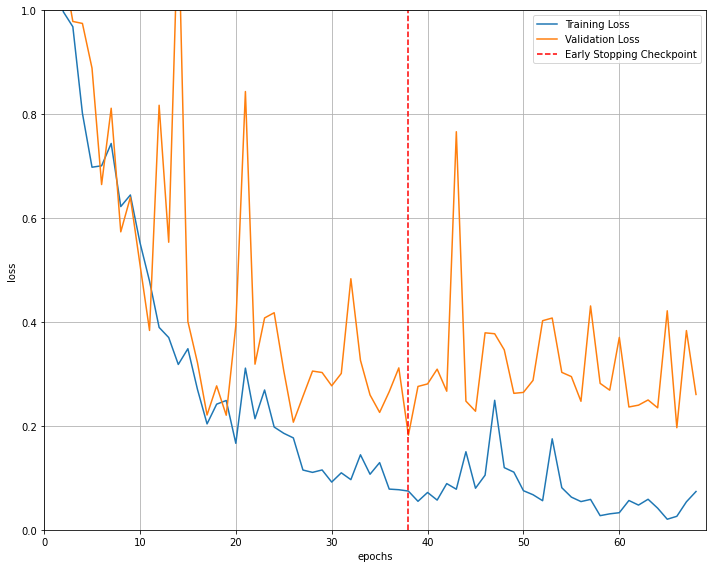

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

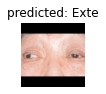

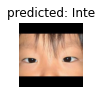

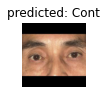

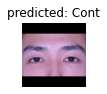

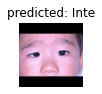

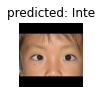

In [ ]:
visualize_model(model_ft)

In [ ]:
#ネットワークの保存
PATH = '/content/drive/My Drive/Deep_learning/Strabismus_3classes.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
#ネットワークの読み込み
PATH = '/content/drive/My Drive/Deep_learning/Strabismus_3classes.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#**Evaluation using confusion matrix, and draw ROC curve**

In [ ]:
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import confusion_matrix
from sklearn import metrics


def make_cm(matrix, columns):
    # matrix numpy配列

    # columns 項目名リスト
    n = len(columns)

    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm


"""
#デプロイ用のモデルに変更する
copy_model_ft = model_ft
copy_model_ft.eval()
model_ft = repvgg_model_convert(copy_model_ft, create_RepVGG_A2).to(device)
"""

model_ft.eval() # prep model for evaluation

targets, preds, probs =[], [], []
for image_tensor, target in dataloaders['test']:  
      #target = target.squeeze(1)     
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)
      #_, pred = torch.max(output, 1)  
      prob, pred = torch.topk(nn.Softmax(dim=1)(output), 1)
      
      preds.append(int(pred))  #予測結果
      targets.append(int(target)) #ラベル

      #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
      prob = abs(1-float(prob)-float(pred))
      probs.append(prob)  #予測結果(確率)

y_test = np.array(targets)
y_pred = np.array(preds)
y_prob = np.array(probs)

print(y_test)
print(y_pred)
#print(y_prob)


# 混同行列(confusion matrix)の取得
labels = class_names
matrix = confusion_matrix(y_test, y_pred)

print(matrix)

# make_cmを使った混同行列標示
cm = make_cm(matrix, labels)

# 結果の表示
display(cm)


tn, fp, fn, tp = matrix.flatten()
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp) #positive predictive value
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1_score = 2*tp/(2*tp+fp+fn)

#感度・特異度の計算
print()
print('accuracy: '+str(accuracy))
print('positive predictive value: '+str(precision))
print('sensitivity: '+str(sensitivity))
print('specificity: '+str(specificity))
print('f1_score: '+str(f1_score))
print()


fpr, tpr, thres = metrics.roc_curve(y_test, y_prob)
auc = metrics.auc(fpr, tpr)
print('auc:', auc)

#Draw AUC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2]
[0 1 2 2 2 0 0 0 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2]
[[ 5  1  4]
 [ 0 16  0]
 [ 1  0 17]]


予測結果          
           Cont Exte Inte
正解データ Cont    5    1    4
      Exte    0   16    0
      Inte    1    0   17

ValueError: ignored

In [ ]:
#Save result into CSV file

image_path = glob.glob(data_dir + "/test/*/*")
#random.shuffle(image_path)  #表示順をランダムにする
print('number of images: ' +str(len(image_path)))
print(image_path) 

#評価モードにする
copy_model_ft = model_ft
copy_model_ft.eval()

#デプロイ用のモデルに変更する
#model_ft = repvgg_model_convert(copy_model_ft, create_RepVGG_A2).to(device)


#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)
    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる
    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label):
    output = model_ft(image_tensor)
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)
    #model_pred:クラス名前、prob:確率、pred:クラス番号
    prob, pred = torch.topk(nn.Softmax(dim=1)(output), 1)
    model_pred = class_names[pred]
    #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
    prob = abs(1-float(prob)-float(pred))
    return model_pred, prob, pred


#ここからがメイン
image_name_list = []
label_list = []
model_pred_list = []
hum_pred_list = []

model_pred_class = []
model_pred_prob = []


df_AI = pd.DataFrame([], columns = ["image_name", "label", "model_pred"])

k=0
for i in image_path:
      print(i)
      image_name, label = getlabel(i)  #画像の名前とラベルを取得
      image_tensor = image_transform(i)  #予測のための画像下処理
      model_pred, prob, pred = image_eval(image_tensor, label)  #予測結果を出力   
      #print('Image: '+ image_name)
      #print('Label: '+ label)
      #print('Pred: '+ model_pred)
      #showImage(i)  #画像を表示
      #print() #空白行を入れる
      time.sleep(0.1)

      image_name_list.append(image_name)
      label_list.append(label)
      model_pred_list.append(model_pred)

      model_pred_class.append(int(pred))
      model_pred_prob.append(float(prob))

      addRow = [image_name, label, model_pred]
      df_AI.loc[k,:] = addRow
      k+=1

print(df_AI)


#リストをCSVファイルに出力
df_AI.to_csv("/content/drive/MyDrive/Deep_learning/Strabismus/3classes_test_AI_result.csv")


number of images: 44
['/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/9595.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/8739.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/9256.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/8728.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/7111.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/6868.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/6738.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/4796.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/5169.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus/dataset(3class_notcut)/test/Cont/3092.jpg', '/content/drive/MyDrive/Deep_learning/Strabismus

#**GradCAM**

In [ ]:
class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

# Split model in two parts
features_fn = nn.Sequential(*list(model_ft.children())[:-2]) #最後の2層（AdaptiveAvgPool2dとLinear)を取り除いたもの
classifier_fn = nn.Sequential(*(list(model_ft.children())[-2:-1] + [Flatten()] + list(model_ft.children())[-1:])) #最終層の前にFlatten()を挿入
 #最後の2層

#評価モードにする    
model_ft = model_ft.eval()
model_ft = model_ft.to(device)

In [ ]:
def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size() #[1,2048,7,7]
    out = classifier_fn(feats) #out: [1,1000]
    c_score = out[0, c]   #c_scoreとは？？

    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)           #ここでGlobalAveragePoolingをしている
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0) #ReLUと同じ
    return sal

read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    lambda x: torch.unsqueeze(x, 0) #次元を1に引き延ばす
])

In [ ]:
#画像のパスを指定
#for j in range(1):
for j in range(len(image_datasets['test'])):

    #元画像

    image = image_datasets['test'][j][0]
    image = image.permute(1, 2, 0)

    img_tensor = image_datasets['test'][j][0].unsqueeze(0)
    #Softmaxにかけたときの確率上位1つのpp(確率)とcc(class番号)を取得(tench→正常,goldfish→斜視)
    pp, cc = torch.topk(nn.Softmax(dim=1)(model_ft(img_tensor.to(device))), 1)

    #pとcを対にして入力
    for i, (p, c) in enumerate(zip(pp[0], cc[0])):  
        sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
        tmp = image.to('cpu').detach().numpy().copy()
        img = Image.fromarray((tmp*255).astype(np.uint8))
        #TensorをImageに変換
        sal = Image.fromarray(sal)
        sal = sal.resize(img.size, resample=Image.LINEAR)

        print()
        #print(img_path) #あとで参照しやすいように画像のパスを表示

        #plt.title('')
        print('label: '+labels[image_datasets['test'][j][1]])
        print('pred:  '+'{}  {:.1f}%'.format(labels[c], 100*float(p)))
        #plt.title('pred:'+'{}: { .1f}%'.format(labels[c], 100*float(p)))        
        
        plt.figure(figsize=(15, 10))

        #グラフを1行2列に並べたうちの1番目
        plt.subplots_adjust(wspace=0,hspace=0)
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.imshow(img)
        plt.imshow(np.array(sal), alpha=0.5, cmap='jet')

        #元の画像を並べて表示
        image = image_datasets['test'][j][0]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.imshow(image)

    plt.show()

#**ネットワークの保存と読み込み**

In [ ]:
#ネットワークの保存
PATH = '/content/drive/My Drive/Deep_learning/GravCont_RepVGG-A2_ImageNet_seed'+str(manualSeed)+'.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
#ネットワークの読み込み
PATH = '/content/drive/My Drive/Deep_learning/GravCont_RepVGG-A2_ImageNet_seed'+str(manualSeed)+'.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>